In [ ]:
#ИМПОРТ И ФУНКЦИИ С КЛАССАМИ
import os
import glob
import h5py
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from IPython.display import clear_output
from IPython.display import Audio, display
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tqdm

# выбираем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#класс датасета
class AudioDataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.file = h5py.File(h5_path, 'r')
        
        self.spectrograms = self.file['spectrograms']
        self.labels = self.file['labels']
        self.class_names = [name.decode('utf-8') for name in self.file.attrs['class_names']]
        self.num_classes = self.file.attrs['num_classes']
        
        print(f"Loaded {len(self.spectrograms)} samples from HDF5")
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        # Загружаем непосредственно из HDF5
        spectrogram = torch.tensor(self.spectrograms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return spectrogram, label
    
    def __del__(self):
        if hasattr(self, 'file'):
            self.file.close()
    
    def get_class_names(self):
        return self.class_names 
#функция потерь (для теста)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()
#CNN + classifier    
class AudioCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        
        super(AudioCNN, self).__init__()
        
        # вход - [1, 128, 512]
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 32, (3,7), padding=(1,3)), 
            nn.ReLU(),
            nn.MaxPool2d(2),    # [32, 64, 256]
            nn.Dropout(0.1),
            
            nn.Conv2d(32, 64, (3,7), padding=(1,3)), 
            nn.ReLU(),
            nn.MaxPool2d(2),    # [64, 32, 128]
            nn.Dropout(0.15),
            
            nn.Conv2d(64, 128, (3,9), padding=(1,4)),
            nn.ReLU(),
            nn.MaxPool2d(2),    # [128, 16, 64]
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, (3,11), padding=(1,5)),
            nn.ReLU(),
            nn.MaxPool2d(2, 4),    # [256, 8, 16]
            nn.Dropout(0.25),
            
            nn.Conv2d(256, 256, (3,11), padding=(1,5)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(8, 8),    # [256, 8, 8]
            nn.Dropout(0.3),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.35),

            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x
    
#полносвязная
class SimpleFCModel(nn.Module):
    def __init__(self, num_classes: int, input_height: int, input_width: int, hidden_size: int = 256):
        super(SimpleFCModel, self).__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        
        # Вычисляем размер после вытягивания в вектор
        self.flatten_size = input_height * input_width
        
        self.layers = nn.Sequential(
            # Вытягиваем в плоский вектор
            nn.Flatten(),
            
            # Первый скрытый слой
            nn.Linear(self.flatten_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),  # для регуляризации
            
            # Второй скрытый слой (можно добавить больше)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(), 
            nn.Dropout(0.4),
            
            # Выходной слой
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        x = self.layers(x)
        return x
#метрики
def calculate_all_metrics(y_true, y_pred, loss):
    
    metrics = {}
    # Loss
    metrics['loss'] = loss
    # F1 Macro - баланс между классами (ОСНОВНАЯ)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    # Precision Macro - контроль false positive
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    # Recall Macro - контроль false negative
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    return metrics

def train_epoch(model, loader, optimizer, criterion, epoch, num_epochs, threshold):
    model.train()
    all_targets = []
    all_predictions = []
    all_loss = 0.0
    output = []
    
    # Создаем прогресс-бар
    pbar = tqdm.tqdm(loader, desc=f'Epoch {epoch}/{num_epochs}', 
                bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    
    for data, targets in pbar:
        data = data.to(device)
        targets = targets.to(device)   
        optimizer.zero_grad()                          
        outputs = model(data)                          
        loss = criterion(outputs, targets)             
        all_loss += loss.item()

        loss.backward()                                
        optimizer.step()                                 
        
        # Сохраняем предсказания и цели для метрик
        with torch.no_grad():            
            probs = torch.sigmoid(outputs)    
            # threshold = probs.quantile(0.93).item()           
            predictions = (probs > threshold).float()            
            all_targets.append(targets.cpu())           
            all_predictions.append(predictions.cpu())
            
        # Обновляем прогресс-бар
        current_loss = all_loss / (pbar.n + 1)
        pbar.set_postfix({'Loss': f'{current_loss:.4f}'})

    all_targets = torch.cat(all_targets).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_loss /= len(loader)

    return calculate_all_metrics(all_targets, all_predictions, all_loss)

def evaluate_epoch(model, loader, criterion, threshold):
    model.eval()
    all_targets = []
    all_predictions = []
    all_loss = 0.0
    
    with torch.no_grad():
        for data, targets in loader:  
            data = data.to(device)
            targets = targets.to(device) 
            outputs = model(data)                       
            loss = criterion(outputs, targets)
            all_loss += loss.item()
            
            probs = torch.sigmoid(outputs)   
            # threshold = probs.quantile(0.93).item()
            predictions = (probs > threshold).float()   
            
            all_targets.append(targets.cpu())          
            all_predictions.append(predictions.cpu())
    
    all_targets = torch.cat(all_targets).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_loss /= len(loader)

    return calculate_all_metrics(all_targets, all_predictions, all_loss)

def train_model(model, train_loader, val_loader, optimizer, criterion, patience=10,
                num_epochs=50, threshold=0.5, save_dir='../data/models'):

    os.makedirs(save_dir, exist_ok=True)

    history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': [],
        'train_precision': [], 'val_precision': [],
        'train_recall': [], 'val_recall': [],
        'train_threshold':[], 'val_threshold':[]
    }
    
    best_f1 = 0.0
    patience_counter = 0

    for epoch in range(1, num_epochs + 1):

        # Обучение и валидация
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, epoch, num_epochs, threshold)
        val_metrics = evaluate_epoch(model, val_loader, criterion, threshold)
        
        # Сохраняем историю
        history['train_loss'].append(train_metrics['loss'])
        history['val_loss'].append(val_metrics['loss'])
        history['train_f1'].append(train_metrics['f1_macro'])
        history['val_f1'].append(val_metrics['f1_macro'])
        history['train_precision'].append(train_metrics['precision_macro'])
        history['val_precision'].append(val_metrics['precision_macro'])
        history['train_recall'].append(train_metrics['recall_macro'])
        history['val_recall'].append(val_metrics['recall_macro'])

        # Выводим метрики
        print("─" * 50)
        print(f"Train >>> Loss: {train_metrics['loss']:.4f} | F1: {train_metrics['f1_macro']:.4f} | "
              f"Precision: {train_metrics['precision_macro']:.4f} | Recall: {train_metrics['recall_macro']:.4f} | ")
        print(f"Val   >>> Loss: {val_metrics['loss']:.4f} | F1: {val_metrics['f1_macro']:.4f} | "
              f"Precision: {val_metrics['precision_macro']:.4f} | Recall: {val_metrics['recall_macro']:.4f} | ")

        # Early stopping и сохранение лучшей модели
        if val_metrics['f1_macro'] > best_f1:
            best_f1 = val_metrics['f1_macro']
            torch.save(model.state_dict(), f'{save_dir}/best_model.pth')
            patience_counter = 0
            print(f"Новая лучшая модель сохранена! F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            print(f"Нет улучшений: ({patience_counter}/{patience})")
            
        if patience_counter >= patience:
            print(f"Ранняя остановка на эпохе {epoch}.")
            break

        print("\n")

    torch.save(model.state_dict(), f'{save_dir}/last_model.pth')

    return history, best_f1

def load_model(model, model_path, strict=True):
    try:
        # Проверяем существование файла
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Не найден файл: {model_path}")
        
        # Загружаем веса
        state_dict = torch.load(model_path, map_location=device)
        
        # Загружаем веса в модель
        model.load_state_dict(state_dict, strict=strict)
        
        return model
        
    except Exception as e:
        print(f"Ошибка загрузки модели: {e}")
        return None

def plot_training_history(history, save_path=None):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('История тренировки', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # 1. Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. F1 Score
    axes[0, 1].plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    axes[0, 1].plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    axes[0, 1].set_title('F1 Macro Score')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision
    axes[1, 0].plot(epochs, history['train_precision'], 'b-', label='Train Precision', linewidth=2)
    axes[1, 0].plot(epochs, history['val_precision'], 'r-', label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Precision Macro')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Recall
    axes[1, 1].plot(epochs, history['train_recall'], 'b-', label='Train Recall', linewidth=2)
    axes[1, 1].plot(epochs, history['val_recall'], 'r-', label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Recall Macro')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Graphs saved to: {save_path}")
    
    plt.show()

def calculate_pos_weight(dataset, smoothing=1.0):
    all_targets = []
    for i in range(len(dataset)):
        _, targets = dataset[i]
        all_targets.append(targets)

    all_targets = torch.stack(all_targets)
    
    positive_counts = all_targets.sum(dim=0) + smoothing
    negative_counts = (all_targets.size(0) - all_targets.sum(dim=0)) + smoothing
    
    pos_weight = negative_counts / positive_counts
    pos_weight = torch.log(pos_weight + 1)
    pos_weight = pos_weight / max(pos_weight)
    
    # pos_weight = torch.clamp(pos_weight, max=max_weight)
    # pos_weight = torch.clamp(pos_weight, min=0.3) 

    print(f"Коррекция весов: {pos_weight}")

    return pos_weight.to(device)



In [2]:
# ЗАГРУЗКА ДАТАСЕТА
# ----------------------------------------------------------
tags_dict = {}
# открываем подготовленный словрь
with open("../data/track_tags.pkl", 'rb') as file:
    tags_dict = pickle.load(file)

# загружаем датасет
dataset = AudioDataset("../data/preprocessed_dataset.h5")



# разбиваем датасет на train и test
dataset_size = len(dataset)
indices = list(range(dataset_size))

train_idx, test_idx = train_test_split(
    indices, 
    test_size = 0.2,
    train_size = 0.8,       
    random_state = 42        # для воспроизводимости
)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,  
    num_workers=8,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,  
    num_workers=4,   
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=2
)

for data, targets in train_loader:
    print(f"DATA - shape: {data.shape}")
    print(f"       min: {data.min().item():.4f}, max: {data.max().item():.4f}")
    print(f"       mean: {data.mean().item():.4f}, std: {data.std().item():.4f}")
    print(f"target exemple: {targets[0]}")
    break

Loaded 18486 samples from HDF5
DATA - shape: torch.Size([128, 1, 128, 512])
       min: -13.8155, max: 12.3532
       mean: 0.6180, std: 4.2191
target exemple: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])


Используется устройство: cuda
Количество параметров модели: 2336827


Epoch 1/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.10it/s, Loss=0.0362]


──────────────────────────────────────────────────
Train >>> Loss: 0.0362 | F1: 0.0393 | Precision: 0.0315 | Recall: 0.0570 | 
Val   >>> Loss: 0.0385 | F1: 0.0428 | Precision: 0.0312 | Recall: 0.1722 | 
Новая лучшая модель сохранена! F1: 0.0428




Epoch 2/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0285]


──────────────────────────────────────────────────
Train >>> Loss: 0.0285 | F1: 0.0220 | Precision: 0.0488 | Recall: 0.0224 | 
Val   >>> Loss: 0.0329 | F1: 0.0310 | Precision: 0.0227 | Recall: 0.0816 | 
Нет улучшений: (1/10)




Epoch 3/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0278]


──────────────────────────────────────────────────
Train >>> Loss: 0.0278 | F1: 0.0213 | Precision: 0.0406 | Recall: 0.0210 | 
Val   >>> Loss: 0.0287 | F1: 0.0297 | Precision: 0.0335 | Recall: 0.0577 | 
Нет улучшений: (2/10)




Epoch 4/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0273]


──────────────────────────────────────────────────
Train >>> Loss: 0.0273 | F1: 0.0249 | Precision: 0.0808 | Recall: 0.0250 | 
Val   >>> Loss: 0.0288 | F1: 0.0317 | Precision: 0.0277 | Recall: 0.0638 | 
Нет улучшений: (3/10)




Epoch 5/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0269]


──────────────────────────────────────────────────
Train >>> Loss: 0.0269 | F1: 0.0286 | Precision: 0.0674 | Recall: 0.0289 | 
Val   >>> Loss: 0.0276 | F1: 0.0326 | Precision: 0.0261 | Recall: 0.0610 | 
Нет улучшений: (4/10)




Epoch 6/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0267]


──────────────────────────────────────────────────
Train >>> Loss: 0.0267 | F1: 0.0311 | Precision: 0.0770 | Recall: 0.0325 | 
Val   >>> Loss: 0.0265 | F1: 0.0285 | Precision: 0.0272 | Recall: 0.0461 | 
Нет улучшений: (5/10)




Epoch 7/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0264]


──────────────────────────────────────────────────
Train >>> Loss: 0.0264 | F1: 0.0344 | Precision: 0.0739 | Recall: 0.0366 | 
Val   >>> Loss: 0.0265 | F1: 0.0338 | Precision: 0.0287 | Recall: 0.0513 | 
Нет улучшений: (6/10)




Epoch 8/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0262]


──────────────────────────────────────────────────
Train >>> Loss: 0.0262 | F1: 0.0389 | Precision: 0.0716 | Recall: 0.0410 | 
Val   >>> Loss: 0.0258 | F1: 0.0319 | Precision: 0.0385 | Recall: 0.0329 | 
Нет улучшений: (7/10)




Epoch 9/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0260]


──────────────────────────────────────────────────
Train >>> Loss: 0.0260 | F1: 0.0429 | Precision: 0.1047 | Recall: 0.0458 | 
Val   >>> Loss: 0.0258 | F1: 0.0411 | Precision: 0.0362 | Recall: 0.0583 | 
Нет улучшений: (8/10)




Epoch 10/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0258]


──────────────────────────────────────────────────
Train >>> Loss: 0.0258 | F1: 0.0469 | Precision: 0.0946 | Recall: 0.0497 | 
Val   >>> Loss: 0.0256 | F1: 0.0390 | Precision: 0.0344 | Recall: 0.0557 | 
Нет улучшений: (9/10)




Epoch 11/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0256]


──────────────────────────────────────────────────
Train >>> Loss: 0.0256 | F1: 0.0558 | Precision: 0.1059 | Recall: 0.0572 | 
Val   >>> Loss: 0.0255 | F1: 0.0457 | Precision: 0.0778 | Recall: 0.0582 | 
Новая лучшая модель сохранена! F1: 0.0457




Epoch 12/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0253]


──────────────────────────────────────────────────
Train >>> Loss: 0.0253 | F1: 0.0616 | Precision: 0.1183 | Recall: 0.0626 | 
Val   >>> Loss: 0.0251 | F1: 0.0658 | Precision: 0.1186 | Recall: 0.0795 | 
Новая лучшая модель сохранена! F1: 0.0658




Epoch 13/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0252]


──────────────────────────────────────────────────
Train >>> Loss: 0.0252 | F1: 0.0719 | Precision: 0.1551 | Recall: 0.0719 | 
Val   >>> Loss: 0.0250 | F1: 0.0725 | Precision: 0.1559 | Recall: 0.0768 | 
Новая лучшая модель сохранена! F1: 0.0725




Epoch 14/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0250]


──────────────────────────────────────────────────
Train >>> Loss: 0.0250 | F1: 0.0824 | Precision: 0.1432 | Recall: 0.0810 | 
Val   >>> Loss: 0.0249 | F1: 0.0775 | Precision: 0.1308 | Recall: 0.0845 | 
Новая лучшая модель сохранена! F1: 0.0775




Epoch 15/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0247]


──────────────────────────────────────────────────
Train >>> Loss: 0.0247 | F1: 0.0958 | Precision: 0.1657 | Recall: 0.0944 | 
Val   >>> Loss: 0.0248 | F1: 0.0930 | Precision: 0.1206 | Recall: 0.1007 | 
Новая лучшая модель сохранена! F1: 0.0930




Epoch 16/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0246]


──────────────────────────────────────────────────
Train >>> Loss: 0.0246 | F1: 0.1033 | Precision: 0.1721 | Recall: 0.1013 | 
Val   >>> Loss: 0.0247 | F1: 0.0818 | Precision: 0.1191 | Recall: 0.0846 | 
Нет улучшений: (1/10)




Epoch 17/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.17it/s, Loss=0.0243]


──────────────────────────────────────────────────
Train >>> Loss: 0.0243 | F1: 0.1124 | Precision: 0.1777 | Recall: 0.1096 | 
Val   >>> Loss: 0.0245 | F1: 0.0960 | Precision: 0.1746 | Recall: 0.0979 | 
Новая лучшая модель сохранена! F1: 0.0960




Epoch 18/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0240]


──────────────────────────────────────────────────
Train >>> Loss: 0.0240 | F1: 0.1270 | Precision: 0.2231 | Recall: 0.1244 | 
Val   >>> Loss: 0.0245 | F1: 0.1172 | Precision: 0.2247 | Recall: 0.1392 | 
Новая лучшая модель сохранена! F1: 0.1172




Epoch 19/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.22it/s, Loss=0.0238]


──────────────────────────────────────────────────
Train >>> Loss: 0.0238 | F1: 0.1376 | Precision: 0.2009 | Recall: 0.1362 | 
Val   >>> Loss: 0.0243 | F1: 0.1111 | Precision: 0.2174 | Recall: 0.1129 | 
Нет улучшений: (1/10)




Epoch 20/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0236]


──────────────────────────────────────────────────
Train >>> Loss: 0.0236 | F1: 0.1477 | Precision: 0.2194 | Recall: 0.1459 | 
Val   >>> Loss: 0.0245 | F1: 0.1226 | Precision: 0.1975 | Recall: 0.1316 | 
Новая лучшая модель сохранена! F1: 0.1226




Epoch 21/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0233]


──────────────────────────────────────────────────
Train >>> Loss: 0.0233 | F1: 0.1585 | Precision: 0.2157 | Recall: 0.1562 | 
Val   >>> Loss: 0.0242 | F1: 0.1336 | Precision: 0.1952 | Recall: 0.1486 | 
Новая лучшая модель сохранена! F1: 0.1336




Epoch 22/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0230]


──────────────────────────────────────────────────
Train >>> Loss: 0.0230 | F1: 0.1717 | Precision: 0.2343 | Recall: 0.1728 | 
Val   >>> Loss: 0.0242 | F1: 0.1340 | Precision: 0.2154 | Recall: 0.1359 | 
Новая лучшая модель сохранена! F1: 0.1340




Epoch 23/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0227]


──────────────────────────────────────────────────
Train >>> Loss: 0.0227 | F1: 0.1780 | Precision: 0.2411 | Recall: 0.1785 | 
Val   >>> Loss: 0.0241 | F1: 0.1442 | Precision: 0.1805 | Recall: 0.1577 | 
Новая лучшая модель сохранена! F1: 0.1442




Epoch 24/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0224]


──────────────────────────────────────────────────
Train >>> Loss: 0.0224 | F1: 0.1937 | Precision: 0.2357 | Recall: 0.1972 | 
Val   >>> Loss: 0.0242 | F1: 0.1355 | Precision: 0.1955 | Recall: 0.1403 | 
Нет улучшений: (1/10)




Epoch 25/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.20it/s, Loss=0.0221]


──────────────────────────────────────────────────
Train >>> Loss: 0.0221 | F1: 0.2057 | Precision: 0.2466 | Recall: 0.2106 | 
Val   >>> Loss: 0.0242 | F1: 0.1553 | Precision: 0.2285 | Recall: 0.1643 | 
Новая лучшая модель сохранена! F1: 0.1553




Epoch 26/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.17it/s, Loss=0.0219]


──────────────────────────────────────────────────
Train >>> Loss: 0.0219 | F1: 0.2128 | Precision: 0.2604 | Recall: 0.2196 | 
Val   >>> Loss: 0.0243 | F1: 0.1482 | Precision: 0.2118 | Recall: 0.1550 | 
Нет улучшений: (1/10)




Epoch 27/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0214]


──────────────────────────────────────────────────
Train >>> Loss: 0.0214 | F1: 0.2264 | Precision: 0.2571 | Recall: 0.2363 | 
Val   >>> Loss: 0.0245 | F1: 0.1614 | Precision: 0.1797 | Recall: 0.1755 | 
Новая лучшая модель сохранена! F1: 0.1614




Epoch 28/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0210]


──────────────────────────────────────────────────
Train >>> Loss: 0.0210 | F1: 0.2426 | Precision: 0.2636 | Recall: 0.2588 | 
Val   >>> Loss: 0.0246 | F1: 0.1559 | Precision: 0.1743 | Recall: 0.1789 | 
Нет улучшений: (1/10)




Epoch 29/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0207]


──────────────────────────────────────────────────
Train >>> Loss: 0.0207 | F1: 0.2529 | Precision: 0.2714 | Recall: 0.2728 | 
Val   >>> Loss: 0.0247 | F1: 0.1631 | Precision: 0.1860 | Recall: 0.1886 | 
Новая лучшая модель сохранена! F1: 0.1631




Epoch 30/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0202]


──────────────────────────────────────────────────
Train >>> Loss: 0.0202 | F1: 0.2693 | Precision: 0.2782 | Recall: 0.2933 | 
Val   >>> Loss: 0.0249 | F1: 0.1552 | Precision: 0.1813 | Recall: 0.1709 | 
Нет улучшений: (1/10)




Epoch 31/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0199]


──────────────────────────────────────────────────
Train >>> Loss: 0.0199 | F1: 0.2793 | Precision: 0.2849 | Recall: 0.3095 | 
Val   >>> Loss: 0.0248 | F1: 0.1625 | Precision: 0.1657 | Recall: 0.1878 | 
Нет улучшений: (2/10)




Epoch 32/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0194]


──────────────────────────────────────────────────
Train >>> Loss: 0.0194 | F1: 0.3006 | Precision: 0.3036 | Recall: 0.3367 | 
Val   >>> Loss: 0.0252 | F1: 0.1657 | Precision: 0.1799 | Recall: 0.1899 | 
Новая лучшая модель сохранена! F1: 0.1657




Epoch 33/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0190]


──────────────────────────────────────────────────
Train >>> Loss: 0.0190 | F1: 0.3179 | Precision: 0.3100 | Recall: 0.3597 | 
Val   >>> Loss: 0.0256 | F1: 0.1606 | Precision: 0.1613 | Recall: 0.1928 | 
Нет улучшений: (1/10)




Epoch 34/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.22it/s, Loss=0.0186]


──────────────────────────────────────────────────
Train >>> Loss: 0.0186 | F1: 0.3267 | Precision: 0.3117 | Recall: 0.3752 | 
Val   >>> Loss: 0.0258 | F1: 0.1671 | Precision: 0.1786 | Recall: 0.1931 | 
Новая лучшая модель сохранена! F1: 0.1671




Epoch 35/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0181]


──────────────────────────────────────────────────
Train >>> Loss: 0.0181 | F1: 0.3422 | Precision: 0.3150 | Recall: 0.4012 | 
Val   >>> Loss: 0.0259 | F1: 0.1723 | Precision: 0.1671 | Recall: 0.2142 | 
Новая лучшая модель сохранена! F1: 0.1723




Epoch 36/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0177]


──────────────────────────────────────────────────
Train >>> Loss: 0.0177 | F1: 0.3645 | Precision: 0.3328 | Recall: 0.4291 | 
Val   >>> Loss: 0.0264 | F1: 0.1669 | Precision: 0.1721 | Recall: 0.1969 | 
Нет улучшений: (1/10)




Epoch 37/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0172]


──────────────────────────────────────────────────
Train >>> Loss: 0.0172 | F1: 0.3729 | Precision: 0.3343 | Recall: 0.4443 | 
Val   >>> Loss: 0.0266 | F1: 0.1677 | Precision: 0.1716 | Recall: 0.2024 | 
Нет улучшений: (2/10)




Epoch 38/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0169]


──────────────────────────────────────────────────
Train >>> Loss: 0.0169 | F1: 0.3848 | Precision: 0.3372 | Recall: 0.4665 | 
Val   >>> Loss: 0.0273 | F1: 0.1708 | Precision: 0.1593 | Recall: 0.2070 | 
Нет улучшений: (3/10)




Epoch 39/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0164]


──────────────────────────────────────────────────
Train >>> Loss: 0.0164 | F1: 0.4071 | Precision: 0.3558 | Recall: 0.4947 | 
Val   >>> Loss: 0.0274 | F1: 0.1734 | Precision: 0.1653 | Recall: 0.2093 | 
Новая лучшая модель сохранена! F1: 0.1734




Epoch 40/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0162]


──────────────────────────────────────────────────
Train >>> Loss: 0.0162 | F1: 0.4130 | Precision: 0.3568 | Recall: 0.5052 | 
Val   >>> Loss: 0.0276 | F1: 0.1661 | Precision: 0.1574 | Recall: 0.1990 | 
Нет улучшений: (1/10)




Epoch 41/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0157]


──────────────────────────────────────────────────
Train >>> Loss: 0.0157 | F1: 0.4275 | Precision: 0.3671 | Recall: 0.5261 | 
Val   >>> Loss: 0.0281 | F1: 0.1712 | Precision: 0.1569 | Recall: 0.2205 | 
Нет улучшений: (2/10)




Epoch 42/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0153]


──────────────────────────────────────────────────
Train >>> Loss: 0.0153 | F1: 0.4405 | Precision: 0.3759 | Recall: 0.5451 | 
Val   >>> Loss: 0.0288 | F1: 0.1671 | Precision: 0.1556 | Recall: 0.2099 | 
Нет улучшений: (3/10)




Epoch 43/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0149]


──────────────────────────────────────────────────
Train >>> Loss: 0.0149 | F1: 0.4512 | Precision: 0.3806 | Recall: 0.5653 | 
Val   >>> Loss: 0.0293 | F1: 0.1667 | Precision: 0.1614 | Recall: 0.2061 | 
Нет улучшений: (4/10)




Epoch 44/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0147]


──────────────────────────────────────────────────
Train >>> Loss: 0.0147 | F1: 0.4614 | Precision: 0.3884 | Recall: 0.5780 | 
Val   >>> Loss: 0.0293 | F1: 0.1632 | Precision: 0.1451 | Recall: 0.2132 | 
Нет улучшений: (5/10)




Epoch 45/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0144]


──────────────────────────────────────────────────
Train >>> Loss: 0.0144 | F1: 0.4680 | Precision: 0.3936 | Recall: 0.5868 | 
Val   >>> Loss: 0.0296 | F1: 0.1650 | Precision: 0.1476 | Recall: 0.2112 | 
Нет улучшений: (6/10)




Epoch 46/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.18it/s, Loss=0.0141]


──────────────────────────────────────────────────
Train >>> Loss: 0.0141 | F1: 0.4814 | Precision: 0.4009 | Recall: 0.6094 | 
Val   >>> Loss: 0.0302 | F1: 0.1636 | Precision: 0.1495 | Recall: 0.2028 | 
Нет улучшений: (7/10)




Epoch 47/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.21it/s, Loss=0.0138]


──────────────────────────────────────────────────
Train >>> Loss: 0.0138 | F1: 0.4853 | Precision: 0.4077 | Recall: 0.6093 | 
Val   >>> Loss: 0.0308 | F1: 0.1626 | Precision: 0.1397 | Recall: 0.2146 | 
Нет улучшений: (8/10)




Epoch 48/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0134]


──────────────────────────────────────────────────
Train >>> Loss: 0.0134 | F1: 0.4982 | Precision: 0.4130 | Recall: 0.6344 | 
Val   >>> Loss: 0.0306 | F1: 0.1669 | Precision: 0.1467 | Recall: 0.2133 | 
Нет улучшений: (9/10)




Epoch 49/100: 100%|████████████████████| 116/116 [00:22<00:00,  5.19it/s, Loss=0.0132]


──────────────────────────────────────────────────
Train >>> Loss: 0.0132 | F1: 0.5067 | Precision: 0.4203 | Recall: 0.6447 | 
Val   >>> Loss: 0.0313 | F1: 0.1631 | Precision: 0.1434 | Recall: 0.2112 | 
Нет улучшений: (10/10)
Ранняя остановка на эпохе 49.


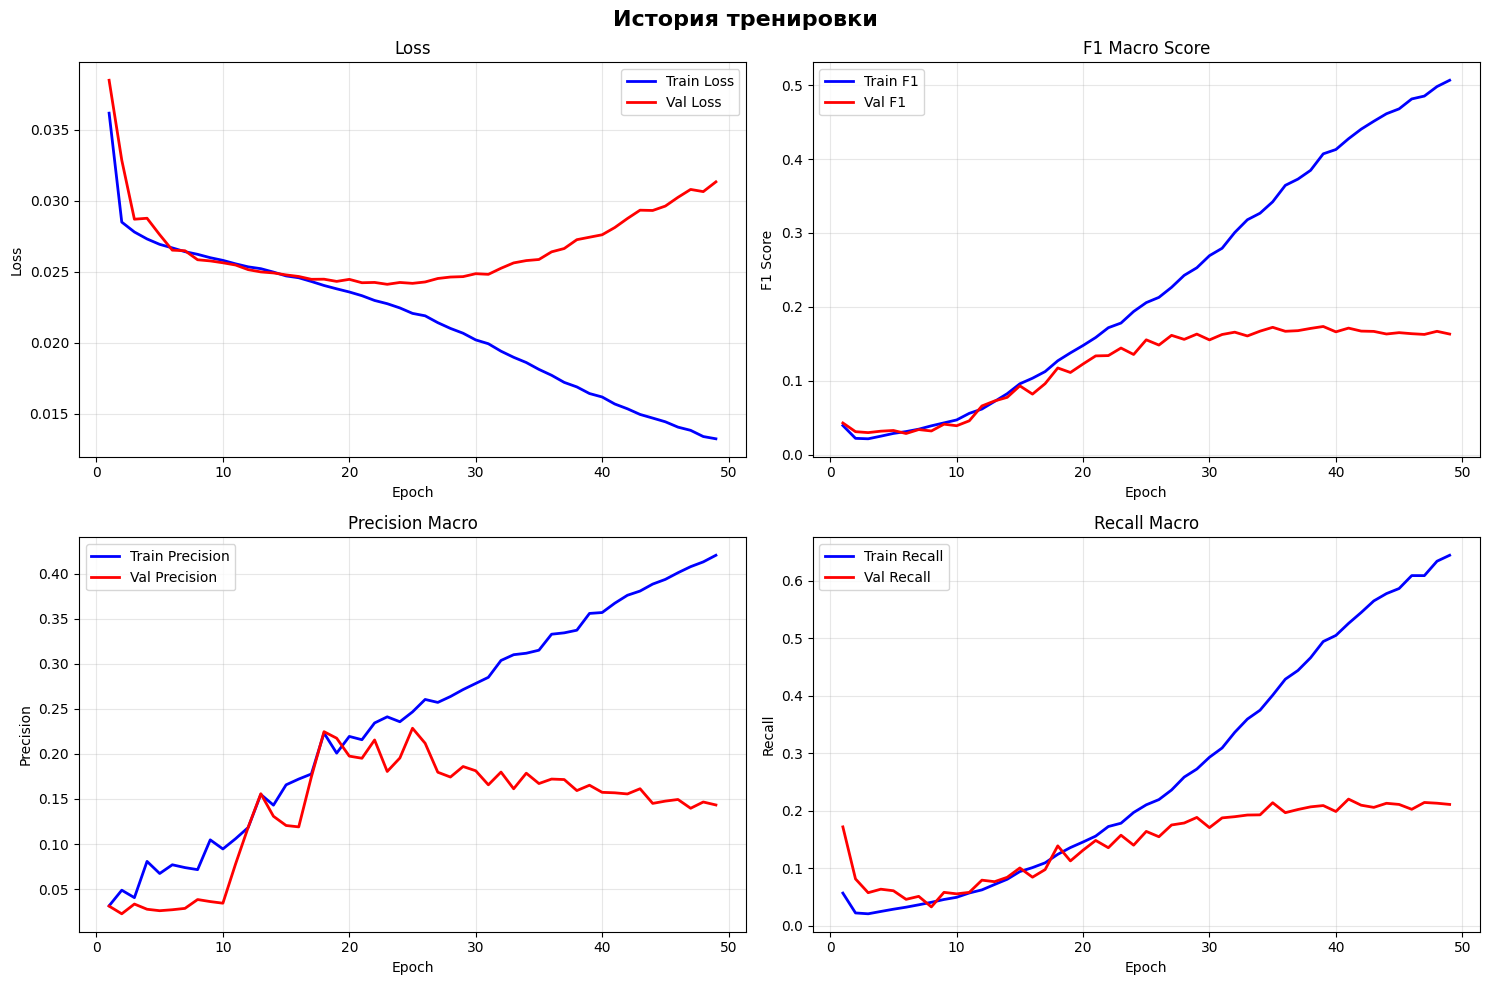

=== MULTI-LABEL DEBUG ===
Outputs range: [-31.715, 7.204]
Probabilities range: [0.000, 0.999]
Sample 0 predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 0 targets:     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 0 matched:     2 correct positive tags
Batch accuracy: 0.971
Positive tag accuracy: 0.885
=== MODEL DEBUG ===
Input data range: [-13.816, 12.723]
Input data mean: 0.811
Model outputs range: [-14.812, 4.093]
Model outputs mean: -2.741
Gradient conv_layers.0.weight: 0.001220
Gradient conv_layers.0.bias: 0.000356
Gradient conv_layers.4.weight: 0.000044
Gradient conv_layers.4.bias: 0.000092
Gradient conv_layers.8.weight: 0.000026
Gradient conv_layers.8.bias: 0.000075
Gradient classifier.1.wei

In [ ]:
#ОБУЧЕНИЕ МОДЕЛИ
def debug_model_predictions(model, loader, threshold=0.5):
    model.eval()
    
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > threshold).float()  # ⚡ Multi-hot вектор!
            
            print("=== MULTI-LABEL DEBUG ===")
            print(f"Outputs range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            print(f"Probabilities range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
            
            # Правильная интерпретация
            print(f"Sample 0 predictions: {predictions[0].cpu().numpy()}")
            print(f"Sample 0 targets:     {targets[0].cpu().numpy()}")
            print(f"Sample 0 matched:     {((predictions[0] == targets[0]) & (targets[0] == 1)).sum().item()} correct positive tags")
            
            # Статистика по батчу
            batch_accuracy = ((predictions == targets).float().mean().item())
            positive_accuracy = ((predictions[targets == 1] == 1).float().mean().item())
            
            print(f"Batch accuracy: {batch_accuracy:.3f}")
            print(f"Positive tag accuracy: {positive_accuracy:.3f}")
            break
def debug_model_outputs(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            print("=== MODEL DEBUG ===")
            print(f"Input data range: [{data.min():.3f}, {data.max():.3f}]")
            print(f"Input data mean: {data.mean():.3f}")
            
            # Проверяем выходы каждого слоя
            print(f"Model outputs range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            print(f"Model outputs mean: {outputs.mean():.3f}")
            
            # Проверяем градиенты
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    print(f"Gradient {name}: {param.grad.abs().mean():.6f}")
                else:
                    print(f"Gradient {name}: None")
            
            break
def debug_model_weights():
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name:30} mean: {param.data.mean().item():8.4f} std: {param.data.std().item():8.4f}")
        elif 'bias' in name:
            print(f"{name:30} mean: {param.data.mean().item():8.4f}")

num_epochs = 10           # количество эпох для обучения
threshold = 0.5             # для предсказаний
patience = 10              # остановка обучения после N эпох без улучшений

# Инициализация модели
model = AudioCNN(dataset.num_classes)
model.to(device)

print(f"Используется устройство: {device}")
print(f"Количество параметров модели: {sum(p.numel() for p in model.parameters())}")

criterion = FocalLoss(alpha=1, gamma=2)
#criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCEWithLogitsLoss(calculate_pos_weight(dataset))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Загрузка модели
#model = load_model(model, "../data/models/best_model.pth")

# Запуск обучения
history, best_f1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    threshold = threshold,
    save_dir='../data/models',
    patience=patience
)

# вывод графиков
plot_training_history(history)

debug_model_predictions(model, train_loader, threshold)
debug_model_outputs(model, train_loader)

In [4]:
import torchaudio 

def random_audio_predictor(model, preprocess_function, class_names, folder_path='../data/train/', device='cuda', threshold=0.5):
    """
    Случайный выбор аудио файла с автовоспроизведением и предсказанием тегов
    """
    
    print("🎲 СЛУЧАЙНЫЙ АУДИО АНАЛИЗ")
    print("=" * 50)
    
    # Находим все аудио файлы в папке
    audio_extensions = ['*.wav', '*.mp3', '*.flac', '*.m4a', '*.ogg']
    audio_files = []
    
    for ext in audio_extensions:
        # Ищем файлы в основной папке и подпапках
        audio_files.extend(glob.glob(os.path.join(folder_path, '**', ext), recursive=True))
        audio_files.extend(glob.glob(os.path.join(folder_path, ext)))
    
    if not audio_files:
        print(f"❌ В папке {folder_path} не найдено аудио файлов!")
        return None
    
    # print(f"📁 Папка: {folder_path}")
    # print(f"📊 Найдено файлов: {len(audio_files)}")
    # print(f"🎚️  Порог: {threshold}")
    
    # Выбираем случайный файл
    selected_file = random.choice(audio_files)
    filename = os.path.basename(selected_file)
    file_path = os.path.dirname(selected_file)
    
    # print(f"\n🎯 Выбран файл: {filename}")
    # print(f"📂 Путь: {file_path}")
    # print("─" * 50)
    

    # Автовоспроизведение аудио
    print("🔊 Автовоспроизведение...")
    display(Audio(selected_file, autoplay=True))
        
    # Предсказание тегов
    print("\n🤖 Анализ тегов...")
    probs, active_tags = quick_predict(
        model=model,
        audio_path=selected_file,
        preprocess_function=preprocess_function,
        class_names=class_names,
        device=device,
        threshold=threshold
    )
    
    if probs is not None:
        # Выводим результаты
        print(f"\n🏷️  ПРЕДСКАЗАННЫЕ ТЕГИ:")
        print("─" * 30)
        
        if active_tags:
            print(f"✅ Найдено тегов: {len(active_tags)}")
            print("\n📋 Список тегов:")
            for tag in active_tags:
                prob = probs[class_names.index(tag)]
                print(f"   • {tag}: {prob:.3f}")
        else:
            print("❌ Нет тегов выше порога")
        
        # # Топ-10 всех предсказаний
        # top_indices = np.argsort(probs)[::-1][:10]
        # print(f"\n🔝 Топ-10 всех предсказаний:")
        # for i, idx in enumerate(top_indices, 1):
        #     prob = probs[idx]
        #     tag = class_names[idx]
        #     marker = "✅" if prob > threshold else "  "
        #     print(f"   {i:2d}. {marker} {tag:<25} {prob:.3f}")
        
        new_dict = {}
        for key, vals in tags_dict.items():
            new_dict[key[3:]] = vals

        print(f"Правильные теги: {new_dict.get(filename, "none")}")

        # Статистика
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего возможных тегов: {len(class_names)}")
        print(f"   Активных тегов: {len(active_tags)}")
        print(f"   Максимальная вероятность: {max(probs):.3f}")
        print(f"   Средняя вероятность: {np.mean(probs):.3f}")
            
        return {
            'file': selected_file,
            'filename': filename,
            'probs': probs,
            'active_tags': active_tags,
            'threshold': threshold
        }           

def preprocess_audio(audio_path, target_sr = 22050, noise = False, start=2048, size=512) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    #уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=22050,
        n_mels=128,        
        n_fft=2048,       
        hop_length=512,
        f_min=20,
        f_max=11025
    )(waveform)

    mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

    # добавим немного шума (это скорее всего сильно замедлит подготовку данных)
    if noise:
        for x in mel_spectrogram:
            x += random.uniform(-1.0, 1.0)

    return mel_spectrogram[0,:start,:start+size]

def quick_predict(model, audio_path, preprocess_function, class_names, device='cuda', threshold=0.5):
    """
    Функция предсказания тегов для аудио файла
    """
    model.to(device)
    model.eval()
    
    try:
        # Препроцессинг
        mel_spec = preprocess_function(audio_path)
        
        # Добавляем batch dimension и перемещаем на устройство
        if len(mel_spec.shape) == 3:  # [channels, height, width]
            input_tensor = mel_spec.unsqueeze(0)  # [1, channels, height, width]
        else:
            input_tensor = mel_spec.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width]
        
        input_tensor = input_tensor.to(device)
        
        # Предсказание
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Собираем активные теги
        active_tags = []
        for i, (class_name, prob) in enumerate(zip(class_names, probs)):
            if prob > threshold:
                active_tags.append(class_name)
        
        return probs, active_tags
        
    except Exception as e:
        print(f"❌ Ошибка во время предсказания: {e}")
        return None, None

best_model = AudioCNN(dataset.num_classes)
load_model(best_model, '../data/models/best_model.pth')
best_model.to(device)
best_model.eval()

# Простой вызов - один случайный файл
random_audio_predictor(
    model=best_model,
    preprocess_function=preprocess_audio,
    class_names=dataset.get_class_names(),
    folder_path='../data/train', #'/home/egr/Музыка',  # Ваша папка с аудио
    device=device,
    threshold=0.4  # Можно настроить порог
)


🎲 СЛУЧАЙНЫЙ АУДИО АНАЛИЗ
🔊 Автовоспроизведение...



🤖 Анализ тегов...


/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3


🏷️  ПРЕДСКАЗАННЫЕ ТЕГИ:
──────────────────────────────
❌ Нет тегов выше порога
Правильные теги: {'documentary', 'corporate'}

📊 СТАТИСТИКА:
   Всего возможных тегов: 59
   Активных тегов: 0
   Максимальная вероятность: 0.381
   Средняя вероятность: 0.167


{'file': '../data/train/35/968435.mp3',
 'filename': '968435.mp3',
 'probs': array([0.11552751, 0.21440315, 0.26644924, 0.09338882, 0.29195172,
        0.12456984, 0.23610307, 0.2443692 , 0.2307917 , 0.18385106,
        0.16163884, 0.19596687, 0.10343044, 0.11063507, 0.3338053 ,
        0.22477338, 0.10999606, 0.25704733, 0.28718227, 0.31872964,
        0.10905325, 0.09848243, 0.26294643, 0.22240774, 0.10020274,
        0.15602903, 0.09467478, 0.24847004, 0.03996571, 0.11932222,
        0.08152227, 0.05891298, 0.1379724 , 0.18863216, 0.18929252,
        0.15217152, 0.11042702, 0.38116965, 0.09817448, 0.2011866 ,
        0.2085955 , 0.05028969, 0.16504456, 0.05495112, 0.32530454,
        0.12312849, 0.22886135, 0.10724008, 0.11969221, 0.04348468,
        0.240687  , 0.15185405, 0.11407995, 0.05163054, 0.11171814,
        0.08490872, 0.24288093, 0.11852246, 0.12882634], dtype=float32),
 'active_tags': [],
 'threshold': 0.4}